In [1]:
from datetime import timedelta, datetime

import data
import numpy as np
from main import initiate_models, run_models
import scipy.interpolate as inter
import pickle
import math

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)

In [2]:
fname = "../results/patchsize.txt"
params, _ = data.get_params()
biom_data, *_ = data.get_data()

patch_factor = {
    'RG': 6, 'BG': 6, 'MG': 3, 'RP': 2, 'BP': 2, 'MP': 1
}

In [3]:
start_date = data.measurements[0]
NDVI_raw = [
    ('01/05/2017', 0.51261703),
    ('01/08/2017', 0.370376023),
    ('01/10/2017', 0.50643531),
    ('01/02/2018', 0.552589066),
    ('01/04/2018', 0.462722544),
    ('01/08/2018', 0.204188518)
]

date_format = "%d/%m/%Y"
NDVI = [((datetime.strptime(date, date_format) - start_date).days, val) for date, val in NDVI_raw]

NDVI_spline = inter.InterpolatedUnivariateSpline(*zip(*NDVI))

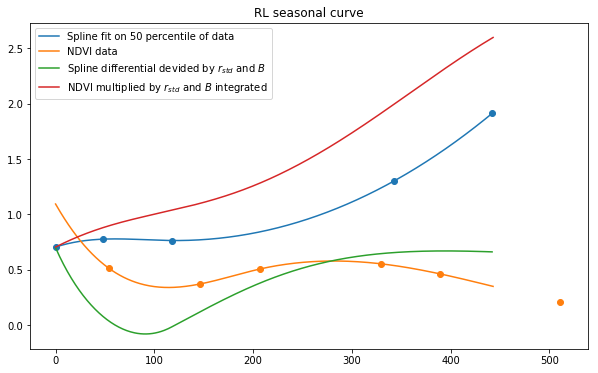

In [12]:
RL_data = []
for key in biom_data.keys():
    if key[-1] == 'R':
        for i in range(patch_factor[key[2:4]]):
            RL_data.append(biom_data[key])
RL_cumulative = np.nanmean(np.vstack(RL_data), axis=0)

# Do a spline fit to data
dates = data.measurements
date_ax = [(date - dates[0]).days for date in dates]
RL_spline = inter.InterpolatedUnivariateSpline(date_ax, RL_cumulative)

days = range((dates[-1] - dates[0]).days + 2)
cumm = RL_spline(days)
diff = np.diff(RL_spline(days)) / params['R_g']
seasonal_RL = diff/ (cumm[:-1])

seasonal_int = [RL_cumulative[0]]
for L_ext in NDVI_spline(days)[:-1]:
    growth = L_ext * params['R_g'] * seasonal_int[-1]
    seasonal_int.append(seasonal_int[-1] + growth)

plt.scatter(date_ax, RL_cumulative)
plt.plot(days, cumm, label="Spline fit on 50 percentile of data")
plt.scatter(*zip(*NDVI))
plt.plot(days, NDVI_spline(days), label="NDVI data")
plt.plot(days[:-1], seasonal_RL, label="Spline differential devided by $r_{std}$ and $B$")
plt.plot(days, seasonal_int, label="NDVI multiplied by $r_{std}$ and $B$ integrated")
plt.title("RL seasonal curve")
plt.legend()
plt.savefig('../results/RL_seasonal.png')
plt.show()

In [13]:
# Save RL specific seasonal function

seasonal_RL_dict = {}
for day, val in zip(days, seasonal_RL):
    seasonal_RL_dict[start_date + timedelta(days=day)] = val

pickle_obj = open("../data/seasonal_RL.dict", "wb")
pickle.dump(seasonal_RL_dict, pickle_obj)
pickle_obj.close()

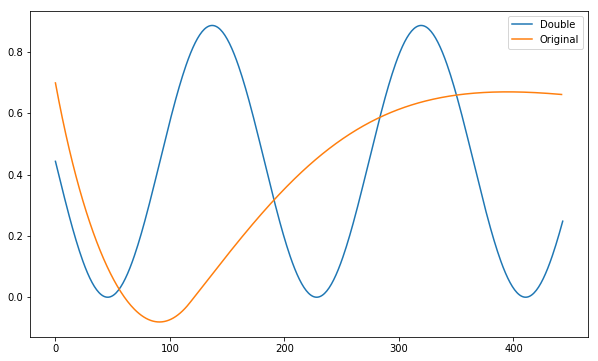

In [14]:
# Generate RL specific seasonal function with double growth season

integrated = np.sum(seasonal_RL)
seasonal_RL_double = [1 - math.sin(2*2*np.pi*day/365) for day in days]
fact = np.sum(seasonal_RL_double)/integrated
plt.plot(seasonal_RL_double/fact, label='Double')
plt.plot(seasonal_RL, label='Original')
plt.legend()
plt.show()

In [15]:
seasonal_RL_double_dict = {}
for day, val in zip(days, seasonal_RL_double):
    seasonal_RL_double_dict[start_date + timedelta(days=day)] = val

pickle_obj = open("../data/seasonal_RL_double.dict", "wb")
pickle.dump(seasonal_RL_double_dict, pickle_obj)
pickle_obj.close()

[0.2171     0.29796294 0.34574113 0.41227482 0.46071135]


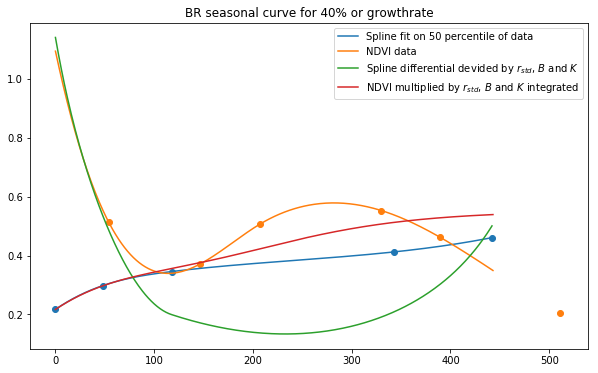

In [16]:
params, _ = data.get_params()

BR_data = []
for key in biom_data.keys():
    if key[-1] == 'B':# and 'P' in key:
        for i in range(patch_factor[key[2:4]]):
            BR_data.append(biom_data[key] / 9)
BR_cumulative = np.nanmean(np.vstack(BR_data), axis=0)
print(BR_cumulative)
# Do a spline fit to data
dates = data.measurements
date_ax = [(date - dates[0]).days for date in dates]
BR_spline = inter.InterpolatedUnivariateSpline(date_ax, BR_cumulative)

days = range((dates[-1] - dates[0]).days + 2)
cumm = BR_spline(days)
diff = np.diff(cumm) / params['B_g']

seasonal_int = [BR_cumulative[0]]
for L_ext in NDVI_spline(days)[:-1]:
    growth = L_ext * params['B_g'] * seasonal_int[-1] * (1 - seasonal_int[-1] / params['B_K'])
    seasonal_int.append(seasonal_int[-1] + growth)
seasonal_BR = diff / (cumm[:-1] * (1 - cumm[:-1]/params['B_K']))
    
plt.scatter(date_ax, BR_cumulative)
plt.plot(days, cumm, label="Spline fit on 50 percentile of data")
plt.scatter(*zip(*NDVI))
plt.plot(days, NDVI_spline(days), label="NDVI data")
plt.plot(days[:-1], seasonal_BR, label="Spline differential devided by $r_{std}$, $B$ and $K$")
plt.plot(days, seasonal_int, label="NDVI multiplied by $r_{std}$, $B$ and $K$ integrated")
plt.title("BR seasonal curve for 40% or growthrate")
plt.legend()
plt.savefig('../results/BR_seasonal.png')
plt.show()

In [9]:
seasonal_BR_dict = {}
for day, val in zip(days, seasonal_BR):#NDVI_spline(days)):
    seasonal_BR_dict[start_date + timedelta(days=day)] = val
        
pickle_obj = open("../data/seasonal_BR.dict", "wb")
pickle.dump(seasonal_BR_dict, pickle_obj)
pickle_obj.close()

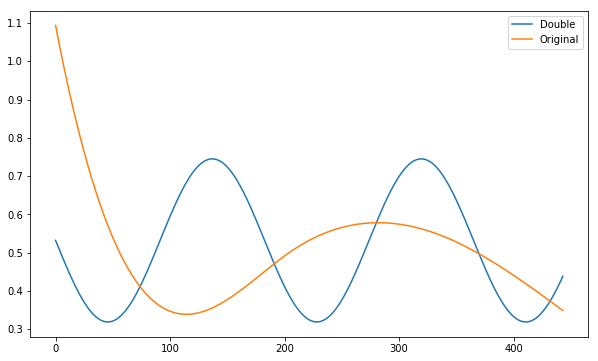

In [10]:
# Generate BR specific seasonal function with double growth season
seasonal_BR = NDVI_spline(days)
integrated = np.sum(seasonal_BR)
seasonal_BR_double = [1 - 0.4*math.sin(2*2*np.pi*day/365) for day in days]
fact = np.sum(seasonal_BR_double)/integrated
plt.plot(seasonal_BR_double/fact, label='Double')
plt.plot(seasonal_BR, label='Original')
plt.legend()
plt.show()

In [11]:
seasonal_BR_double_dict = {}
for day, val in zip(days, seasonal_BR_double):
    seasonal_BR_double_dict[start_date + timedelta(days=day)] = val

pickle_obj = open("../data/seasonal_BR_double.dict", "wb")
pickle.dump(seasonal_BR_double_dict, pickle_obj)
pickle_obj.close()